###This notebook contains some usual analysis for LPA
It only works for output format in pdb.

In [11]:
import numpy as np
import pylab as plt
from lpa_pdb_diagnostics import *
from scipy.constants import e, c, m_e, epsilon_0
import os
import matplotlib
%matplotlib inline

Setting the directory path where the data are located. dir_path has to be correctly attributed before analysis.

In [12]:
dir_path = "//Volumes/Orsay/warp_200MeV_plateau_1600_13dec/data/"
#dir_path = os.getcwd() + "/data"

Setting the path for the results:

In [13]:
res_path = config.result_path

#Laser - Plasma Parameters
Here we define some of the laser plasma parameters.

In [14]:
# Some definitions of the laser plasma parameters
lambda0 = 0.8e-6
w0 = 2*np.pi*c/lambda0
laser_waist = 17e-6
plasma_dens = 4e24
plasma_length = 2.4e-3
wp = np.sqrt(plasma_dens * e**2/ (epsilon_0 * m_e))
lambda_plasma = 2*np.pi*c/wp

#Numerical Parameters
Here we define the necessary numerical parameters for the analysis

In [15]:
zmax = 2*lambda0
zmin = zmax - 6*lambda_plasma
nzplambda = 20
w_size = zmax - zmin
Nz = int(w_size*nzplambda/lambda0)
dz = w_size/Nz

#Generate values for file reading

In [16]:
inf = 0
sup = 0
period_int = 1000
period_ext = 1000
val = values( inf, sup, period_int, period_ext, plasma_length/dz )
longitudinal_position = val*dz

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


We create an array of file names that we analyze.

In [17]:
field = np.empty(len(val),dtype="S100")
N5 = np.empty(len(val),dtype="S100")
N6 = np.empty(len(val),dtype="S100")
N7 = np.empty(len(val),dtype="S100")
H = np.empty(len(val),dtype="S100")

# Initialize file names
for i, v in enumerate(val):
    field[i] = dir_path + "fields%06d.pdb" %v
    N5[i] = dir_path + "N5%06d.pdb" %v
    N6[i] = dir_path + "N6%06d.pdb" %v
    N7[i] = dir_path + "N7%06d.pdb" %v
    H[i] = dir_path + "H%06d.pdb" %v

#Reading files

##Multiple files reading

####Laser $a_0$, Beam spectrum, Big Picture

** Processing ** Fields: Intialisation of //Volumes/Orsay/warp_200MeV_plateau_1600_13dec/data/fields060000.pdb **
** Processing ** Particles: Initialisation of //Volumes/Orsay/warp_200MeV_plateau_1600_13dec/data/H060000.pdb **
** Processing ** Particles: Initialisation of //Volumes/Orsay/warp_200MeV_plateau_1600_13dec/data/N6060000.pdb **
** Processing ** Particles: Initialisation of //Volumes/Orsay/warp_200MeV_plateau_1600_13dec/data/N7060000.pdb **
A file named Charge_density_60000.hdf5 in /Users/pmlee/Documents/LPA_PDB_diagnostics/quickstart_notebook/result/ is created.
A file named Normalized_Fields_60000.hdf5 in /Users/pmlee/Documents/LPA_PDB_diagnostics/quickstart_notebook/result/ is created.
A file named beam_spectrum_60000.hdf5 in /Users/pmlee/Documents/LPA_PDB_diagnostics/quickstart_notebook/result/ is created.


//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


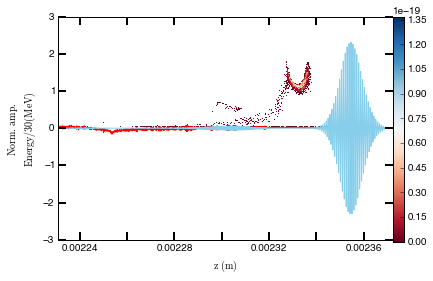

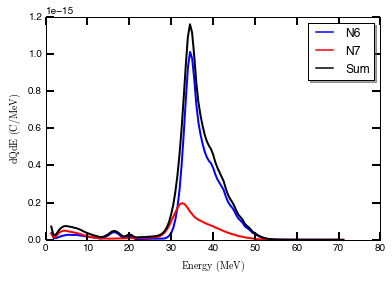

In [18]:
l_particle = True

#preparing some empty arrays
a0 = []
z_a0 = []
emitx = []
emity = []
energy = []
dQdE = []

last = len(val)
first = len(val) - 1
for index in range( first, last ):
    f = FieldInstant( field[index], np.pi/2, 
                 quantities= ["E", "zfield"] )
    a, z = f.laser_a0(w0)
    
    # Store values in arrays
    a0.append(a)
    z_a0.append(z)
    
    if l_particle:
        p_H = ParticleInstant( H[index], quantities = [ "Weight", "Position", "Momentum"] )
        p_N6 = ParticleInstant( N6[index], quantities = [ "Weight", "Position", "Momentum"]  )
        p_N7 = ParticleInstant( N7[index], quantities = [ "Weight", "Position", "Momentum"]  )
        qdict = p_N6.get_qdict()
        
        #Select particles
        cp_H = p_H.select( gamma_threshold = [0,400])
        cp_N6 = p_N6.select( gamma_threshold = [0,400])
        cp_N7 = p_N7.select( gamma_threshold = [0,400])
        
        # Concatenate particles
        ck_all_particles = quant_concatenate([cp_N6,cp_N7], keep_object_name = True ) #keeping the information on the species
        c_all_particles = quant_concatenate([cp_N6, cp_N7])
        
        # Analysing big picture
        N_laser = f.normalizedField( w0, "laser")
        N_wake = f.normalizedField( wp, "wake")
        bigPicture( val[index], c_all_particles[qdict["z"]], c_all_particles[qdict["gamma"]],
           c_all_particles[qdict["w"]], f.zfield, N_wake, N_laser, lwrite= True )
        
        # Analyzing beam spectrum
        t_energy, t_dQdE = beam_spectrum(val[index], 
                             ck_all_particles[qdict["gamma"]], 
                             ck_all_particles[qdict["w"]], lwrite=True,
                             leg = ["N6","N7","Sum"])
        # Store values in arrays
        energy.append( t_energy )
        dQdE.append( t_dQdE )
        
        # Analyzing beam emittance
        t_emitx = beam_emittance( val[index],  c_all_particles, qdict, "x" ) 
        t_emity = beam_emittance( val[index],  c_all_particles, qdict, "y" )
        
        # Store values in arrays
        emitx.append( t_emitx )
        emity.append( t_emity )

Saving laser a0 values in files.

In [19]:
qname = ["z", "a0"]
f = FileWriting(qname, "a0")
stacked_data = np.stack(( z_a0, a0 ), axis=0)
f.write(stacked_data, np.shape(stacked_data), attrs = ["m", "arb. unit"])

A file named a0.hdf5 in /Users/pmlee/Documents/LPA_PDB_diagnostics/quickstart_notebook/result/ is created.


Plotting and saving figure in png format

//anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:2562: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.00235470173022, right=0.00235470173022
  'left=%s, right=%s') % (left, right))


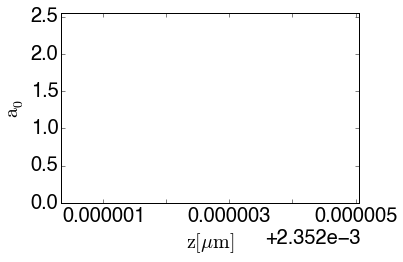

In [20]:
if 'inline' in matplotlib.get_backend():
    fig, ax = plt.subplots( dpi=150 )
else:
    fig, ax = plt.subplots( figsize=(10,8) )
    
fig.patch.set_facecolor('white')
ax.plot(z_a0[1:], a0[1:])
ax.set_xlim(min(z_a0), max(z_a0))
ax.set_ylim(0, 1.1*max(a0))
ax.set_xlabel(r"$\mathrm{z[\mu m]}$")
ax.set_ylabel(r"$\mathrm{a_0}$")
plt.setp(ax.get_xticklabels()[::2], visible=False)
font = {'family':'sans-serif', 'size': 20}
plt.rc('font', **font)
plt.tight_layout()

#Saving file
fig.savefig(res_path + "a0.png", dpi =300)